In [5]:
import os
import csv

from PIL import Image
import matplotlib.pyplot as plt

from util.visualize import show_pyg_graph
import networkx as nx

from data.action_genome import AG

In [2]:
root = '/data/Datasets/ag/'
ag = AG(root)

folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/AKKWU.mp4 does not exist
folder /data/Datasets/ag/frames/AKKWU.mp4 does not exist
folder /data/Datasets/ag/frames/AKKWU.mp4 does not exist
folder /data/Datasets/ag/frames/AKKWU.mp4 does not exist
folder /data/Datasets/ag/frames/AKKWU.mp4 does not exist
folder /data/Datasets/ag/frames/QQ9RN.mp4 does not exist
folder /data/Datasets/ag/frames/8EYHC.mp4 does not exist
folder /data/Datasets/ag/frames/8EYHC.mp4 does not exist
folder /data/Datasets/ag/frames/RTULL.mp4 does not exist
folder /data/Datasets/ag/frames/VKLP7.mp4 does not exist
folder /data/Datasets/ag/frames

In [9]:

# visualize a pyg graph, given the data object, node vocab, and rel vocab
def show_pyg_graph(graph, nodes, rels, layout='circular', curve=None):

    # Create an empty NetworkX directed graph
    G = nx.DiGraph()
    
    # Add nodes with their features
    for i in range(graph.num_nodes):
        G.add_node(i, label=nodes[graph.node_type[i].item()])
    
    # Add edges with their attributes
    edge_index = graph.edge_index
    #edge_attr = graph.edge_attr if 'edge_attr' in graph else None
    edge_type = graph.edge_type if 'edge_attr' in graph else None
    for i in range(edge_index.size(1)):
        source, target = edge_index[:, i].tolist()
        if edge_type is not None:
            label = rels[int(edge_type[i].item())]
            G.add_edge(source, target, label=label)
        else:
            G.add_edge(source, target)
    
    # Draw the graph
    if layout == 'circular':
        pos = nx.circular_layout(G)
    elif layout == 'kamada_kawai':
        pos = nx.kamada_kawai_layout(G)
    else:
        pos = nx.spring_layout(G)
    
    labels = nx.get_node_attributes(G, 'label')
    edge_labels = nx.get_edge_attributes(G, 'label')

    if curve:
        connectionstyle = 'arc3,rad=%f' % curve
    else:
        connectionstyle = 'arc3'
    
    
    nx.draw(G, pos, with_labels=True, labels=labels, node_color='lightblue', node_size=500, font_size=10, font_color='black', font_weight='bold', arrows=True, connectionstyle=connectionstyle)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', horizontalalignment='right', verticalalignment='bottom')

Data(x=[5, 37], edge_index=[2, 13], edge_attr=[13, 26], y=[1], node_type=[5], edge_type=[13], id='S6MPZ.mp4/000012.png')
S6MPZ.mp4/000012.png
tensor([ 1, 17, 32,  8, 24])
tensor([[0, 1, 0, 0, 2, 0, 0, 3, 3, 0, 0, 4, 0],
        [1, 0, 1, 2, 0, 2, 3, 0, 0, 3, 4, 0, 4]])
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0

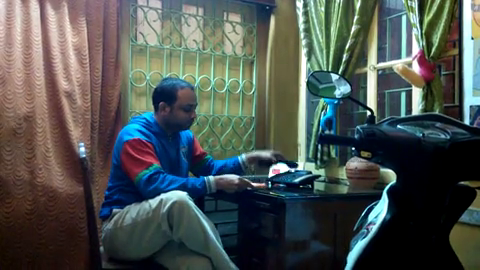

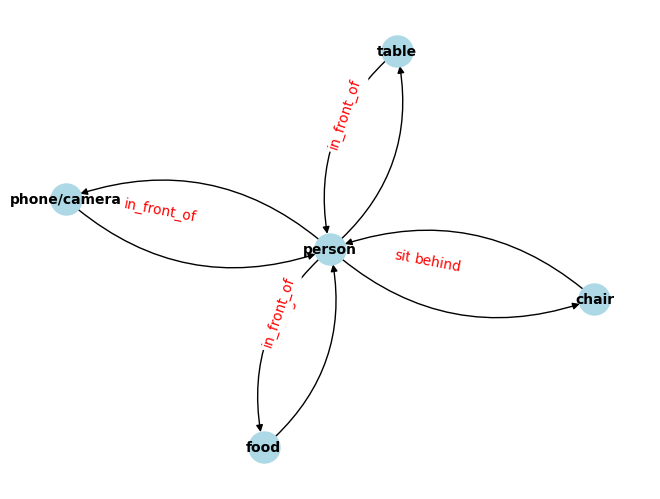

In [10]:
img, sg, action = ag[8]
print(sg)
print(sg.id)
print(sg.node_type)
print(sg.edge_index)
print(sg.edge_attr)

show_pyg_graph(sg, ag.object_classes, ag.relationship_classes, layout='spring', curve=0.3)

display(img)

In [ ]:
from models.ga import GAConstraintLearner

ga = GAConstraintLearner()

In [3]:
b = 'jfjs'
print(f'\\+{b}abc')

\+jfjsabc


In [4]:
arr = ['a', 'b', 'c']
'; '.join(arr)

'a; b; c'